# Investigate Berlin House Prices

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a>
    <ul>
        <li><a href="#gather">Gather</a></li>
        <li><a href="#assess">Assess</a></li>
        <li><a href="#clean">Clean</a></li>
    </ul>
</li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
</ul>

## Introduction

- What are the most expensive areas
- What is the most popular time to publish a new ad.
- Are houses that stay online less than 24 hours
- What characteristics of a house are more important to predict the price.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

<a id='gather'></a>
### Gather

Our dataset is available on a csv file, so all we have to do to import the dataset is by reading the file into memory.

In [2]:
df = pd.read_csv('berlin-houses.csv')
df.head()

,id,lat,lon,cold_price,currency,short_listed,postcode_id,balcony,builtin_kitchen,created_date,...,published_date,warm_price,address,link,quarter,garden,listing_type,localhost_date,no_longer_available,no_longer_available_date
0,108076043,52.54692,13.39993,954.83,EUR,False,13355,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-13 21:28:29.524733,True,2019-06-19 20:59:47.343696
1,109645532,52.46982,13.43096,425.98,EUR,False,12051,True,False,2019-01-30 13:48:26.000000,...,2019-01-30 13:48:26.000000,630.98,"Schierker Straße 31, Neukölln (Neukölln), Berlin",https://www.immobilienscout24.de/expose/109645532,Neukölln (Neukölln),False,S,2019-04-13 21:28:30.204815,True,2019-06-21 06:36:13.552834
2,108077960,52.54727,13.39899,769.99,EUR,False,13355,True,True,2018-10-30 12:28:47.000000,...,2018-10-30 12:28:47.000000,952.47,"Lichtburgring 4, Wedding (Wedding), Berlin",https://www.immobilienscout24.de/expose/108077960,Wedding (Wedding),False,M,2019-04-13 21:28:29.522283,True,2019-06-19 20:59:47.345571
3,109503935,52.51210,13.46197,949.00,EUR,False,10245,False,False,2019-01-23 11:32:09.000000,...,2019-01-23 11:32:09.000000,1139.00,"Boxhagener Str. 98, Friedrichshain (Friedrichs...",https://www.immobilienscout24.de/expose/109503935,Friedrichshain (Friedrichshain),False,M,2019-04-13 21:28:29.538720,True,2019-06-19 20:59:47.352013
4,110143024,52.50508,13.38592,559.96,EUR,False,10963,True,False,2019-02-27 08:55:20.000000,...,2019-02-27 08:55:20.000000,735.51,"Anhalterstraße 11, Kreuzberg (Kreuzberg), Berlin",https://www.immobilienscout24.de/expose/110143024,Kreuzberg (Kreuzberg),False,S,2019-04-13 21:28:30.185993,True,2019-06-19 20:59:47.359163


<a id='assess'></a>
### Assess

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1038 non-null   int64  
 1   lat                       1038 non-null   float64
 2   lon                       1038 non-null   float64
 3   cold_price                1038 non-null   float64
 4   currency                  1038 non-null   object 
 5   short_listed              1038 non-null   bool   
 6   postcode_id               1038 non-null   int64  
 7   balcony                   1038 non-null   bool   
 8   builtin_kitchen           1038 non-null   bool   
 9   created_date              1001 non-null   object 
 10  energy_certificate        1038 non-null   bool   
 11  has_new_flag              1038 non-null   bool   
 12  living_space              1018 non-null   float64
 13  new_home_builder          1038 non-null   bool   
 14  number_r

Looking at the above datatypes, we see that we have 4 different types: objects (string), ints, floats and booleans. On closer inspection, most datatypes seem to be correct except for the postcode, which should be of type object.

In [4]:
df.describe()

,id,lat,lon,cold_price,postcode_id,living_space,number_rooms,warm_price
count,1.038000e+03,1038.000000,1038.000000,1038.000000,1038.000000,1018.000000,1018.000000,1018.000000
mean,1.093818e+08,52.509401,13.423467,787.479653,10851.175337,63.034656,2.212181,966.603143
std,9.737607e+06,0.020471,0.030168,192.510034,831.004776,18.337413,0.477795,218.588139
min,3.140399e+07,52.467010,13.339400,0.000000,10099.000000,40.000000,2.000000,100.000000
25%,1.110968e+08,52.497450,13.400535,666.860000,10245.000000,53.500000,2.000000,817.250000
50%,1.122059e+08,52.508770,13.424590,800.000000,10435.000000,59.930000,2.000000,970.000000
75%,1.125261e+08,52.524010,13.447400,949.000000,10969.000000,69.175000,2.000000,1130.000000
max,1.127994e+08,52.549230,13.494310,1100.000000,13357.000000,456.000000,5.000000,1621.520000


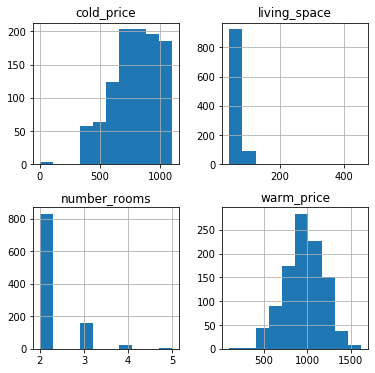

In [5]:
df[['cold_price', 'living_space', 'number_rooms', 'warm_price']].hist(figsize=(6, 6));

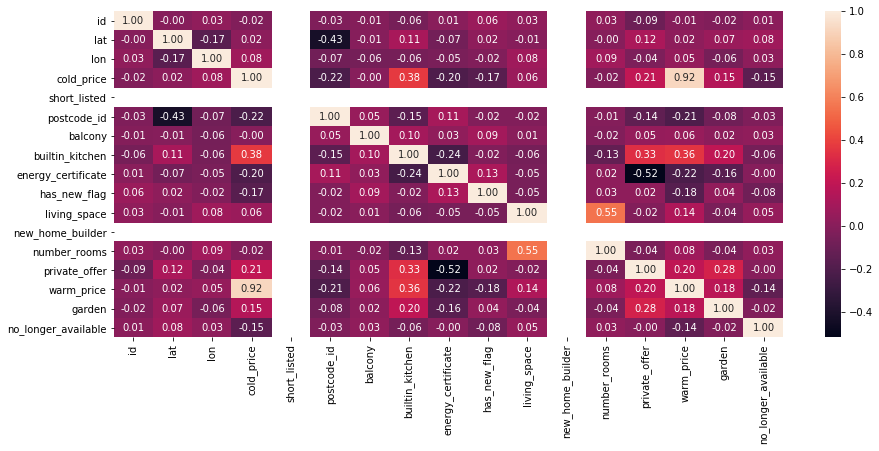

In [6]:
plt.figure(figsize=(15, 6))
sb.heatmap(df.corr(), annot=True, fmt=".2f");

In [7]:
(df.shape[0] - df.count()) / df.shape[0] * 100

id                           0.000000
lat                          0.000000
lon                          0.000000
cold_price                   0.000000
currency                     0.000000
short_listed                 0.000000
postcode_id                  0.000000
balcony                      0.000000
builtin_kitchen              0.000000
created_date                 3.564547
energy_certificate           0.000000
has_new_flag                 0.000000
living_space                 1.926782
new_home_builder             0.000000
number_rooms                 1.926782
private_offer                0.000000
modified_date                1.926782
published_date               3.564547
warm_price                   1.926782
address                      1.926782
link                         1.926782
quarter                      1.926782
garden                       0.000000
listing_type                 1.926782
localhost_date               0.000000
no_longer_available          0.000000
no_longer_av

In [8]:
df.currency.value_counts(dropna=False)

EUR    1038
Name: currency, dtype: int64

In [9]:
df.short_listed.value_counts(dropna=False)

False    1038
Name: short_listed, dtype: int64

In [10]:
df.postcode_id.value_counts(dropna=False)

10969    116
10245     87
10247     76
10243     55
10115     52
10249     49
10405     45
10437     43
10117     34
13355     34
10119     24
12059     24
12053     24
10963     24
12049     24
12051     21
12435     21
12045     21
12055     21
10407     21
10179     21
10435     19
10178     19
12043     18
10961     15
10785     15
10317     14
10967     13
10997     13
10965     12
10999     11
12047     10
10781      7
10823      6
10365      5
10777      4
10827      3
10439      3
10783      3
10787      2
10679      1
10707      1
10779      1
10367      1
10825      1
10248      1
13357      1
10099      1
10235      1
Name: postcode_id, dtype: int64

In [11]:
df.quarter.value_counts(dropna=False)

Friedrichshain (Friedrichshain)      267
Kreuzberg (Kreuzberg)                204
Neukölln (Neukölln)                  161
Mitte (Mitte)                        147
Prenzlauer Berg (Prenzlauer Berg)    134
Wedding (Wedding)                     29
Schöneberg (Schöneberg)               28
NaN                                   20
Lichtenberg (Lichtenberg)             17
Tiergarten (Tiergarten)               15
Treptow (Treptow)                     15
Plänterwald (Treptow)                  1
Name: quarter, dtype: int64

In [12]:
df.listing_type.value_counts(dropna=False)

S      758
M      228
L       27
NaN     20
XL       5
Name: listing_type, dtype: int64

In [13]:
df.number_rooms.value_counts(dropna=False)

2.0    831
3.0    160
4.0     25
NaN     20
5.0      2
Name: number_rooms, dtype: int64

In [14]:
df.new_home_builder.value_counts(dropna=False)

False    1038
Name: new_home_builder, dtype: int64

In [15]:
df.has_new_flag.value_counts(dropna=False)

True     905
False    133
Name: has_new_flag, dtype: int64

In [16]:
df.energy_certificate.value_counts(dropna=False)

True     768
False    270
Name: energy_certificate, dtype: int64

In [17]:
df.balcony.value_counts(dropna=False)

True     632
False    406
Name: balcony, dtype: int64

In [18]:
df.builtin_kitchen.value_counts(dropna=False)

False    578
True     460
Name: builtin_kitchen, dtype: int64

In [19]:
df.private_offer.value_counts(dropna=False)

False    833
True     205
Name: private_offer, dtype: int64

In [20]:
df.garden.value_counts(dropna=False)

False    975
True      63
Name: garden, dtype: int64

In [21]:
df[df.number_rooms.isnull()]

,id,lat,lon,cold_price,currency,short_listed,postcode_id,balcony,builtin_kitchen,created_date,...,published_date,warm_price,address,link,quarter,garden,listing_type,localhost_date,no_longer_available,no_longer_available_date
0,108076043,52.54692,13.39993,954.83,EUR,False,13355,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-13 21:28:29.524733,True,2019-06-19 20:59:47.343696
133,87989317,52.49119,13.40320,682.00,EUR,False,10961,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-23 17:17:46.429389,True,2019-06-19 20:59:47.318677
135,111139962,52.50070,13.46418,750.00,EUR,False,10245,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-23 17:17:46.438342,True,2019-06-21 06:36:13.724755
154,111150063,52.54868,13.39900,924.00,EUR,False,13355,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-23 17:17:46.479311,True,2019-06-19 20:59:47.523904
159,111079921,52.47106,13.43346,655.49,EUR,False,12053,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-18 12:21:42.263275,True,2019-04-18 12:51:42.812337
181,111141306,52.49802,13.48991,888.00,EUR,False,10317,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-23 17:17:46.532199,True,2019-06-19 20:59:47.517946
182,111141541,52.48703,13.46637,799.00,EUR,False,12435,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-23 17:17:46.528689,True,2019-06-19 20:59:47.519911
183,111149077,52.53465,13.43516,670.00,EUR,False,10407,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-04-23 17:17:46.524850,True,2019-06-19 20:59:47.522001
361,112311101,52.48002,13.43807,445.00,EUR,False,12043,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-07-04 16:38:59.542529,True,2019-07-05 22:56:24.596261
451,112316783,52.49413,13.43607,700.00,EUR,False,10999,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,2019-07-05 16:51:24.602817,True,2019-07-06 10:37:15.036043


### Quality

- `postcode_id` can be converted to object type.
- `listing_type` can be converted to categorical type.
- `created_date`, `published_date`, `localhost_date` and `no_longer_available_date` should be of type datetime.
- `currency`, `short_listed`, `new_home_builder` columns have only one value.
- There are 20 listings that seem to be missing most of the data in the columns.
- `address`, `lat` and `lon` columns have too sparse information for insights to come out of these columns. There are other columns enconding location information. `link` column can also be deleted as it does not add any information.

<a id='clean'></a>
### Clean

**- `postcode_id` can be converted to object type**<br>
**- `listing_type` can be converted to categorical type**<br>
**- `created_date`, `published_date`, `localhost_date` and `no_longer_available_date` should be of type datetime**

##### Define
Convert `postcode_id` column to an object type.

##### Code

In [22]:
df.postcode_id = df.postcode_id.astype(str)

datetime_columns = ['created_date', 'published_date', 'localhost_date', 'no_longer_available_date']

for col in datetime_columns:
    df[col] = pd.to_datetime(df[col])
    
cat_var = pd.CategoricalDtype(categories=['S', 'M', 'L', 'XL'], ordered=True)

df['listing_type'] = df['listing_type'].astype(cat_var)

##### Test

In [23]:
df[['postcode_id', 'listing_type', 'created_date', 'published_date', 'localhost_date', 'no_longer_available_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   postcode_id               1038 non-null   object        
 1   listing_type              1018 non-null   category      
 2   created_date              1001 non-null   datetime64[ns]
 3   published_date            1001 non-null   datetime64[ns]
 4   localhost_date            1038 non-null   datetime64[ns]
 5   no_longer_available_date  932 non-null    datetime64[ns]
dtypes: category(1), datetime64[ns](4), object(1)
memory usage: 41.9+ KB


**- `currency`, `short_listed`, `new_home_builder` columns have only one value**

##### Define
As the columns `currency`, `short_listed`, `new_home_builder` add no information to the dataset, we should delete them.

##### Code

In [24]:
columns_to_delete = ['currency', 'short_listed', 'new_home_builder']

df.drop(columns=columns_to_delete, inplace=True)

##### Test

In [25]:
set(df.columns).intersection(set(columns_to_delete))

set()

**- There are 20 listings that seem to be missing most of the data in the columns**

##### Define
These rows seem to be missing most of the data in the columns, and therefore it makes more sense to delete them than to input values to these rows. 

##### Code

In [26]:
df.drop(df[df.number_rooms.isnull()].index, axis=0, inplace=True)

##### Test

In [27]:
df[df.number_rooms.isnull()].index

Int64Index([], dtype='int64')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1018 entries, 1 to 1037
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        1018 non-null   int64         
 1   lat                       1018 non-null   float64       
 2   lon                       1018 non-null   float64       
 3   cold_price                1018 non-null   float64       
 4   postcode_id               1018 non-null   object        
 5   balcony                   1018 non-null   bool          
 6   builtin_kitchen           1018 non-null   bool          
 7   created_date              1001 non-null   datetime64[ns]
 8   energy_certificate        1018 non-null   bool          
 9   has_new_flag              1018 non-null   bool          
 10  living_space              1018 non-null   float64       
 11  number_rooms              1018 non-null   float64       
 12  private_offer       

**- `address`, `lat` and `lon` columns have too sparse information for insights to come out of these columns. There are other columns enconding location information. `link` column can also be deleted as it does not add any information**

##### Define
Delete columns `address`, `lat`, `lon` and `link`.

##### Code

In [29]:
columns_to_delete = ['address', 'lat', 'lon', 'link']

df.drop(columns=columns_to_delete, inplace=True)

##### Test

In [30]:
set(df.columns).intersection(set(columns_to_delete))

set()

<a id='feature_engineering'></a>
### Feature Engineering

**Create column to encode price difference between warm and cold price**

In [31]:
df['price_diff'] = (df['warm_price'] - df['cold_price']) / df['warm_price']

In [32]:
df.describe()

,id,cold_price,living_space,number_rooms,warm_price,price_diff
count,1.018000e+03,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000
mean,1.093620e+08,787.266670,63.034656,2.212181,966.603143,0.187471
std,9.804464e+06,193.263247,18.337413,0.477795,218.588139,0.077290
min,3.140399e+07,0.000000,40.000000,2.000000,100.000000,0.000000
25%,1.110960e+08,664.377500,53.500000,2.000000,817.250000,0.142139
50%,1.122064e+08,800.000000,59.930000,2.000000,970.000000,0.178553
75%,1.125291e+08,949.165000,69.175000,2.000000,1130.000000,0.219800
max,1.127994e+08,1100.000000,456.000000,5.000000,1621.520000,1.000000


The rows where the `price_diff` is `1` should be investigated further.

In [48]:
df[df['price_diff'] == 1][['cold_price', 'warm_price', 'price_diff']]

,cold_price,warm_price,price_diff


These rows happen when the cold price is `0`. As most likely a `cold_price` of `0` is a mistake, we should change the `price_diff` to 0 in these rows, making the warm price and cold price the same.

In [34]:
df.loc[df['cold_price'] == 0, 'price_diff'] = 0

In [35]:
df.describe()

,id,cold_price,living_space,number_rooms,warm_price,price_diff
count,1.018000e+03,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000
mean,1.093620e+08,787.266670,63.034656,2.212181,966.603143,0.185507
std,9.804464e+06,193.263247,18.337413,0.477795,218.588139,0.068853
min,3.140399e+07,0.000000,40.000000,2.000000,100.000000,0.000000
25%,1.110960e+08,664.377500,53.500000,2.000000,817.250000,0.141773
50%,1.122064e+08,800.000000,59.930000,2.000000,970.000000,0.178397
75%,1.125291e+08,949.165000,69.175000,2.000000,1130.000000,0.219797
max,1.127994e+08,1100.000000,456.000000,5.000000,1621.520000,0.466667


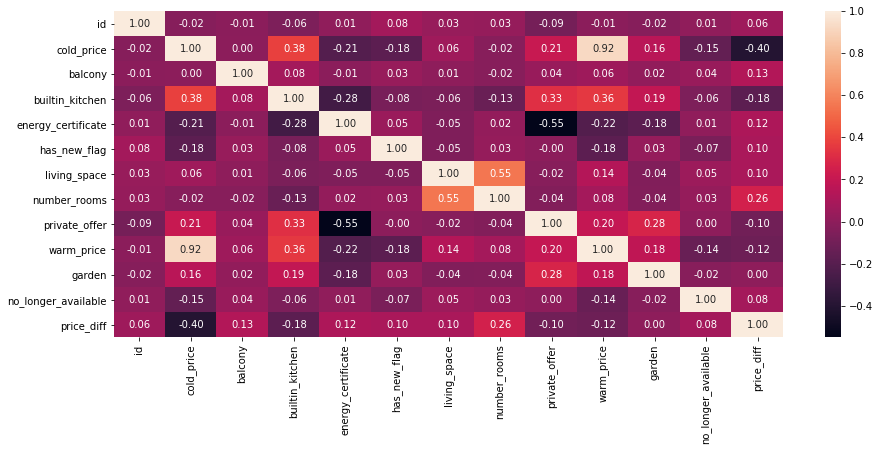

In [37]:
plt.figure(figsize=(15, 6))
sb.heatmap(df.corr(), annot=True, fmt=".2f");

**Create column to encode the amount of time an apartment was published online**

In [52]:
df['time_to_sell'] = df.no_longer_available_date - df.published_date

In [53]:
df.head()

,id,cold_price,postcode_id,balcony,builtin_kitchen,created_date,energy_certificate,has_new_flag,living_space,number_rooms,...,published_date,warm_price,quarter,garden,listing_type,localhost_date,no_longer_available,no_longer_available_date,price_diff,time_to_sell
1,109645532,425.98,12051,True,False,2019-01-30 13:48:26,False,False,59.00,2.0,...,2019-01-30 13:48:26,630.98,Neukölln (Neukölln),False,S,2019-04-13 21:28:30.204815,True,2019-06-21 06:36:13.552834,0.324891,141 days 16:47:47.552834
2,108077960,769.99,13355,True,True,2018-10-30 12:28:47,True,False,51.98,2.0,...,2018-10-30 12:28:47,952.47,Wedding (Wedding),False,M,2019-04-13 21:28:29.522283,True,2019-06-19 20:59:47.345571,0.191586,232 days 08:31:00.345571
3,109503935,949.00,10245,False,False,2019-01-23 11:32:09,True,False,80.00,2.0,...,2019-01-23 11:32:09,1139.00,Friedrichshain (Friedrichshain),False,M,2019-04-13 21:28:29.538720,True,2019-06-19 20:59:47.352013,0.166813,147 days 09:27:38.352013
4,110143024,559.96,10963,True,False,2019-02-27 08:55:20,True,False,64.63,2.0,...,2019-02-27 08:55:20,735.51,Kreuzberg (Kreuzberg),False,S,2019-04-13 21:28:30.185993,True,2019-06-19 20:59:47.359163,0.238678,112 days 12:04:27.359163
5,110364332,923.53,10245,True,False,2019-03-12 13:40:46,True,False,137.84,4.0,...,2019-03-12 13:40:46,1364.62,Friedrichshain (Friedrichshain),False,S,2019-04-13 21:28:30.119240,True,2019-06-19 20:59:47.366053,0.323233,99 days 07:19:01.366053


In [54]:
df.describe()

,id,cold_price,living_space,number_rooms,warm_price,price_diff,time_to_sell
count,1.016000e+03,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,893
mean,1.094427e+08,786.804104,63.031772,2.212598,966.095472,0.185545,12 days 03:06:23.100674
std,9.623095e+06,193.146419,18.355341,0.478173,218.500180,0.068892,24 days 18:37:26.654966
min,3.140399e+07,0.000000,40.000000,2.000000,100.000000,0.000000,0 days 00:21:06.067150
25%,1.110982e+08,664.002500,53.497500,2.000000,816.750000,0.141855,0 days 07:53:37.529219
50%,1.122076e+08,800.000000,59.850000,2.000000,969.720000,0.178397,2 days 01:22:09.788923
75%,1.125295e+08,949.000000,69.200000,2.000000,1130.000000,0.219798,8 days 10:38:31.384541
max,1.127994e+08,1100.000000,456.000000,5.000000,1621.520000,0.466667,232 days 08:31:00.345571


In [46]:
df.drop(df[df['time_to_sell'] > np.timedelta64(300,'D')].index, axis=0, inplace=True)

In [55]:
df.describe()

,id,cold_price,living_space,number_rooms,warm_price,price_diff,time_to_sell
count,1.016000e+03,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,893
mean,1.094427e+08,786.804104,63.031772,2.212598,966.095472,0.185545,12 days 03:06:23.100674
std,9.623095e+06,193.146419,18.355341,0.478173,218.500180,0.068892,24 days 18:37:26.654966
min,3.140399e+07,0.000000,40.000000,2.000000,100.000000,0.000000,0 days 00:21:06.067150
25%,1.110982e+08,664.002500,53.497500,2.000000,816.750000,0.141855,0 days 07:53:37.529219
50%,1.122076e+08,800.000000,59.850000,2.000000,969.720000,0.178397,2 days 01:22:09.788923
75%,1.125295e+08,949.000000,69.200000,2.000000,1130.000000,0.219798,8 days 10:38:31.384541
max,1.127994e+08,1100.000000,456.000000,5.000000,1621.520000,0.466667,232 days 08:31:00.345571


In [63]:
df[df['time_to_sell'] < np.timedelta64(1,'D')]

,id,cold_price,postcode_id,balcony,builtin_kitchen,created_date,energy_certificate,has_new_flag,living_space,number_rooms,...,published_date,warm_price,quarter,garden,listing_type,localhost_date,no_longer_available,no_longer_available_date,price_diff,time_to_sell
8,107686402,664.17,10117,True,True,2019-04-16 08:24:33,True,True,51.09,2.0,...,2019-04-16 08:24:33,784.17,Mitte (Mitte),False,S,2019-04-16 08:54:24.321491,True,2019-04-16 18:18:22.921344,0.153028,09:53:49.921344
57,112095381,950.00,10247,True,True,2019-06-20 13:20:37,True,True,62.00,2.0,...,2019-06-20 13:20:37,1090.00,Friedrichshain (Friedrichshain),False,S,2019-06-20 13:30:58.566391,True,2019-06-21 06:36:13.887079,0.128440,17:15:36.887079
79,112244237,700.00,10115,True,True,2019-06-30 15:12:21,False,True,60.00,2.0,...,2019-06-30 15:12:21,800.00,Mitte (Mitte),False,L,2019-06-30 15:29:44.329497,True,2019-06-30 16:29:49.033822,0.125000,01:17:28.033822
99,104097618,774.00,10247,True,True,2019-04-14 13:03:46,True,True,86.00,2.0,...,2019-04-14 13:03:46,860.00,Friedrichshain (Friedrichshain),False,S,2019-04-14 13:26:41.392973,True,2019-04-14 13:56:41.791961,0.100000,00:52:55.791961
100,111000992,700.00,10243,True,False,2019-04-14 14:42:07,True,True,61.80,2.0,...,2019-04-14 14:42:07,840.00,Friedrichshain (Friedrichshain),False,M,2019-04-14 14:56:42.465323,True,2019-04-14 15:56:43.222163,0.166667,01:14:36.222163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,112716138,413.03,10243,False,False,2019-07-25 09:05:28,True,True,49.54,2.0,...,2019-07-25 09:05:28,535.96,Friedrichshain (Friedrichshain),False,S,2019-07-25 09:07:59.111144,True,2019-07-25 11:28:12.413078,0.229364,02:22:44.413078
1023,112681082,955.00,10969,True,True,2019-07-25 08:06:35,True,True,92.61,3.0,...,2019-07-25 08:06:35,1215.00,Kreuzberg (Kreuzberg),False,S,2019-07-25 08:27:55.176536,True,2019-07-25 11:48:13.702417,0.213992,03:41:38.702417
1024,112715381,583.01,10785,True,False,2019-07-25 08:25:52,True,True,67.09,2.0,...,2019-07-25 08:25:52,747.67,Tiergarten (Tiergarten),False,S,2019-07-25 08:27:55.154152,True,2019-07-25 12:28:16.563628,0.220231,04:02:24.563628
1025,112712241,672.60,10365,True,False,2019-07-25 04:00:56,True,True,83.90,3.0,...,2019-07-25 04:00:56,902.39,Lichtenberg (Lichtenberg),False,S,2019-07-25 04:07:37.308650,True,2019-07-25 16:08:34.307198,0.254646,12:07:38.307198
